# NFL Combine Draft Classification  
## A Logistic Regression Analysis

### Eric Au

<img src="https://library.sportingnews.com/styles/twitter_card_120x120/s3/2022-03/Antoine-Winfield-030222-GETTY-FTR.jpg?itok=nG3hUgf_" width="500" length = "200"/>

Source: <a href="https://www.sportingnews.com/us/nfl/news/nfl-combine-drills-explained-40-yard-dash/lds11epxn7znufqyjkaphguq">Getty Images</a>

### Business and Data Understanding

Every year, the National Football League (NFL) holds a week long showcase where college football players, otherwise known as prospects, perform physical drills and tests in front of team coaches, scouts, and general managers. These drills are intended to measure a player's physical ability such as speed, quickness, strength, and overall athleticism. 

But what can NFL teams learn from these workouts? What exactly do the non-football athletic testing measurements contribute to prospect evaluation? These are a questions that many fans ask to this day and NFL teams try to interpret to make the best decision possible when drafting their players. 

For this analysis, we will be using player combine data scraped from <a href = "https://www.pro-football-reference.com/">Pro-Football Reference</a> over the last 22 years (2000-2022). 

Each record represents an individual player who was eligible to be drafted with information related to their combine measurements. Additionally, each record indicates whether that player was `Drafted` with 1 for "Yes" and 0 for "No". This will be further clarified in the preliminary cleaning of the data set. 

**Create a model that determines whether a player was `Drafted` based on the available data and information provided in the NFL Combine.** 

We will attempt to find any significance between the combine and draft status as well as explore the following: 
- How significant are measurables in determining draft status? 
- What do the metrics distributions look like for the skill positions?

**Stakeholders:** The New York Giants front office (General Manager, President, Scouting Department). 


In [781]:
# import libraries 
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MaxAbsScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, \
RandomizedSearchCV, StratifiedKFold, KFold
from sklearn.feature_selection import SelectFromModel

from sklearn.compose import ColumnTransformer

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import make_scorer

from sklearn.base import clone

# ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None 

In [782]:
# load in data
df = pd.read_csv('Data/combine_2000_2022.csv', index_col = 0)
df.head()

,Player,Pos,School,College,Ht,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Drafted (tm/rnd/yr),Year
0,John Abraham,OLB,South Carolina,NaN,6-4,252.0,4.55,NaN,NaN,NaN,NaN,NaN,New York Jets / 1st / 13th pick / 2000,2000
1,Shaun Alexander,RB,Alabama,College Stats,6-0,218.0,4.58,NaN,NaN,NaN,NaN,NaN,Seattle Seahawks / 1st / 19th pick / 2000,2000
2,Darnell Alford,OT,Boston Col.,NaN,6-4,334.0,5.56,25.0,23.0,94.0,8.48,4.98,Kansas City Chiefs / 6th / 188th pick / 2000,2000
3,Kyle Allamon,TE,Texas Tech,NaN,6-2,253.0,4.97,29.0,NaN,104.0,7.29,4.49,NaN,2000
4,Rashard Anderson,CB,Jackson State,NaN,6-2,206.0,4.55,34.0,NaN,123.0,7.18,4.15,Carolina Panthers / 1st / 23rd pick / 2000,2000


In [783]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7680 entries, 0 to 7820
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Player               7680 non-null   object 
 1   Pos                  7680 non-null   object 
 2   School               7680 non-null   object 
 3   College              6240 non-null   object 
 4   Ht                   7651 non-null   object 
 5   Wt                   7656 non-null   float64
 6   40yd                 7206 non-null   float64
 7   Vertical             5932 non-null   float64
 8   Bench                5096 non-null   float64
 9   Broad Jump           5859 non-null   float64
 10  3Cone                4792 non-null   float64
 11  Shuttle              4895 non-null   float64
 12  Drafted (tm/rnd/yr)  4937 non-null   object 
 13  Year                 7680 non-null   int64  
dtypes: float64(7), int64(1), object(6)
memory usage: 900.0+ KB


## Initial Data Preparation
The following steps below are preliminary data cleaning just to get the dataframe in a working set condition for the `train_test_split`. Handling of missing values will be performed following the split. 

### Convert to float types in appropriate columns; 

In [784]:
# create a list of columns that need to be floats
col_floats = ['Wt', '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle']

In [785]:
# convert to type float for col_floats columns
df[col_floats].astype(float)

,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle
0,252.0,4.55,NaN,NaN,NaN,NaN,NaN
1,218.0,4.58,NaN,NaN,NaN,NaN,NaN
2,334.0,5.56,25.0,23.0,94.0,8.48,4.98
3,253.0,4.97,29.0,NaN,104.0,7.29,4.49
4,206.0,4.55,34.0,NaN,123.0,7.18,4.15
...,...,...,...,...,...,...,...
7816,304.0,4.77,29.0,NaN,111.0,NaN,NaN
7817,255.0,NaN,NaN,NaN,NaN,NaN,NaN
7818,206.0,NaN,NaN,12.0,NaN,NaN,NaN
7819,316.0,5.13,28.5,27.0,110.0,7.75,4.71


### Remove missing data

In [786]:
# there are 29 missing heights in the dataframe
missing_heights = df[df['Ht'].isna()].index
len(missing_heights)

29

In [787]:
# remove these rows from the df
df = df.drop(missing_heights)

In [788]:
# check shape (7680 - 29) = 7651
df.shape

(7651, 14)

### Convert `Height` to appropriate float value

In [789]:
# create feet and inches columns to seperate the 'Ht'
df['feet'] = df['Ht'].str.split("-").str[0].astype(int)
df['inches'] = df['Ht'].str.split("-").str[1].astype(int)

# add new Height column that calculates height as a float
df['Height'] = df['feet'] + round((df['inches']/12),2)

In [790]:
# remove unneeded columns and extra columns created
df = df.drop(columns = ['Player', 'Ht', 'College','feet', 'inches', 'Year'])

In [791]:
# rename the columns
df = df[['Pos', 'School', 'Wt', '40yd', 'Vertical', 'Bench',
       'Broad Jump', '3Cone', 'Shuttle', 'Drafted (tm/rnd/yr)', 'Height']]

### Create binary `Drafted ` Column of 1 - Yes, 0 - No if player was drafted

In [792]:
# fill missing in drafted column with 0
df['Drafted (tm/rnd/yr)'] = df['Drafted (tm/rnd/yr)'].fillna(0)

In [793]:
# create new column Drafted that designates whether drafted (1) or not (0)
df['Drafted'] = np.where(df['Drafted (tm/rnd/yr)'] == 0, 0, 1)

# drop extra drafted column now
df.drop(columns = 'Drafted (tm/rnd/yr)', inplace = True)

In [794]:
df.head(5)

,Pos,School,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Height,Drafted
0,OLB,South Carolina,252.0,4.55,NaN,NaN,NaN,NaN,NaN,6.33,1
1,RB,Alabama,218.0,4.58,NaN,NaN,NaN,NaN,NaN,6.00,1
2,OT,Boston Col.,334.0,5.56,25.0,23.0,94.0,8.48,4.98,6.33,1
3,TE,Texas Tech,253.0,4.97,29.0,NaN,104.0,7.29,4.49,6.17,0
4,CB,Jackson State,206.0,4.55,34.0,NaN,123.0,7.18,4.15,6.17,1


In [795]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7651 entries, 0 to 7820
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pos         7651 non-null   object 
 1   School      7651 non-null   object 
 2   Wt          7651 non-null   float64
 3   40yd        7191 non-null   float64
 4   Vertical    5919 non-null   float64
 5   Bench       5082 non-null   float64
 6   Broad Jump  5850 non-null   float64
 7   3Cone       4784 non-null   float64
 8   Shuttle     4888 non-null   float64
 9   Height      7651 non-null   float64
 10  Drafted     7651 non-null   int64  
dtypes: float64(8), int64(1), object(2)
memory usage: 717.3+ KB


In [796]:
df.head()

,Pos,School,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Height,Drafted
0,OLB,South Carolina,252.0,4.55,NaN,NaN,NaN,NaN,NaN,6.33,1
1,RB,Alabama,218.0,4.58,NaN,NaN,NaN,NaN,NaN,6.00,1
2,OT,Boston Col.,334.0,5.56,25.0,23.0,94.0,8.48,4.98,6.33,1
3,TE,Texas Tech,253.0,4.97,29.0,NaN,104.0,7.29,4.49,6.17,0
4,CB,Jackson State,206.0,4.55,34.0,NaN,123.0,7.18,4.15,6.17,1


In [797]:
df.describe()

,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Height,Drafted
count,7651.000000,7191.000000,5919.000000,5082.000000,5850.000000,4784.000000,4888.000000,7651.000000,7651.000000
mean,242.735852,4.776540,32.892854,20.744392,114.590769,7.284933,4.399677,6.149007,0.643315
std,45.236972,0.304748,4.217085,6.378024,9.351811,0.417687,0.267133,0.220414,0.479052
min,144.000000,4.220000,17.500000,2.000000,74.000000,6.280000,3.730000,5.330000,0.000000
25%,205.000000,4.540000,30.000000,16.000000,109.000000,6.980000,4.200000,6.000000,0.000000
50%,232.000000,4.690000,33.000000,21.000000,116.000000,7.190000,4.360000,6.170000,1.000000
75%,280.000000,4.980000,36.000000,25.000000,121.000000,7.530000,4.560000,6.330000,1.000000
max,384.000000,6.050000,46.500000,49.000000,147.000000,9.120000,5.560000,6.830000,1.000000


## Exploratory Data Analysis

### Position Breakdown

- possibly come back here to see how final model performs based on splitting up by offensive and defensive positions

In [798]:
# check positions available
df['Pos'].value_counts()

WR      1058
CB       761
RB       671
S        559
OT       524
DE       519
DT       497
OLB      430
TE       425
QB       416
OG       403
ILB      276
C        184
LB       154
P        142
OL       139
FB       120
DL       116
K        103
EDGE      65
DB        59
LS        30
Name: Pos, dtype: int64

In [799]:
sorted_positions = df['Pos'].value_counts()
sorted_positions

WR      1058
CB       761
RB       671
S        559
OT       524
DE       519
DT       497
OLB      430
TE       425
QB       416
OG       403
ILB      276
C        184
LB       154
P        142
OL       139
FB       120
DL       116
K        103
EDGE      65
DB        59
LS        30
Name: Pos, dtype: int64

<AxesSubplot:title={'center':'Most Frequent Positions in the NFL Combine (2000 - 2022)'}>

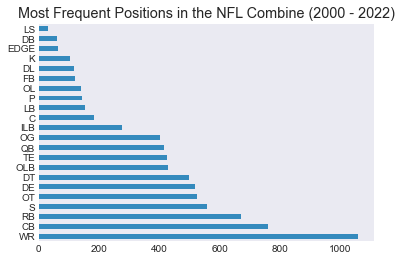

In [800]:
sorted_positions.plot(x = sorted_positions.index,
                      y = sorted_positions.values,
                      kind = 'barh', 
                      title = 'Most Frequent Positions in the NFL Combine (2000 - 2022)')

In [801]:
# create positions_df that orders positions by most frequent to least
positions = ['WR', 'CB', 'RB', 'S', 'OT', 'DE', 'DT', 'OLB', 'TE', 'QB', 'OG', 'ILB',
       'C', 'LB', 'P', 'OL', 'FB', 'DL', 'K', 'EDGE', 'DB', 'LS']

values = [1058,  761,  671,  559,  524,  519,  497,  430,  425,  416,  403,
        276,  184,  154,  142,  139,  120,  116,  103,   65,   59,   30]

data = {'Position': positions,
        'Count': values}

positions_df = pd.DataFrame(data,
                       columns=['Count'], 
                       index = positions)

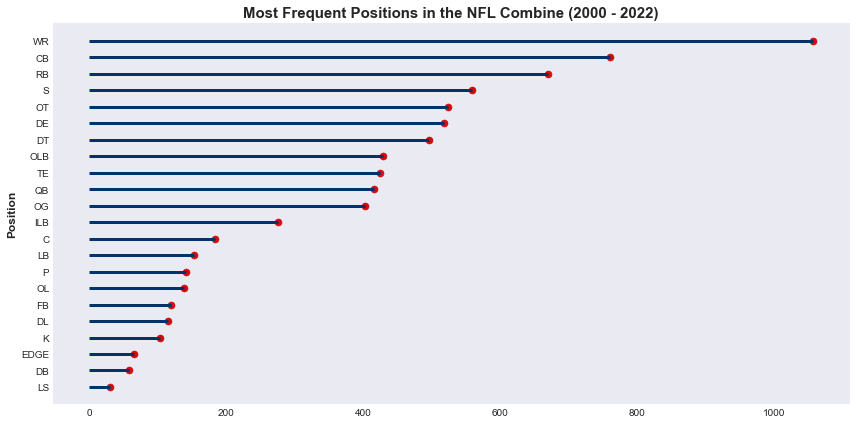

In [802]:
# plot a lollipop plot of most frequent positions in the combine
fig, ax = plt.subplots(figsize=(12, 6))
plt.style.use('bmh')

# create dataframe of positions & number of drafted
ordered_df = positions_df.sort_values(by = 'Count')

# plots the lines
plt.hlines(y = ordered_df.index,  # positions
           xmin = 0,
           xmax = ordered_df['Count'],  # Count values
           color = '#013369', linewidth = 3)

plt.scatter(ordered_df['Count'], # Count values
            ordered_df.index,  # positions
            color='#d50a0a', 
            alpha=1, s = 50)

plt.title('Most Frequent Positions in the NFL Combine (2000 - 2022)', weight = "bold", fontsize = 15)
plt.ylabel('Position', weight = "bold", fontsize = 12)

plt.tight_layout()
plt.show()

In [803]:
# list of offensive positions
offense_list = ['WR', 'RB', 'OT', 'TE', 'QB', 'OG', 'C', 'OL', 'FB']

# list of defensive positions
defense_list = ['CB', 'S', 'DE', 'DT', 'OLB', 'ILB', 'LB', 'DL', 'EDGE', 'DB']

# list of special team positions
special_teams_list = ['LS', 'K', 'P']

In [804]:
# split into offensive positions
offense = df.loc[df['Pos'].isin(offense_list)]

# split into defensive positions
defense = df.loc[df['Pos'].isin(defense_list)]

# split into special teams positions
special_teams = df.loc[df['Pos'].isin(special_teams_list)]

In [805]:
# percent and count breakdowns
# Offense
total_offense = len(offense)
total_offense_drafted = offense['Drafted'].value_counts()[1]
total_offense_undrafted = offense['Drafted'].value_counts()[0]
percent_off_drafted = round(offense['Drafted'].value_counts(normalize = True)[1], 2)
percent_off_undrafted = round(offense['Drafted'].value_counts(normalize = True)[0], 2)

print("Offense")
print(f"Total Players:      {total_offense}")
print(f"Total Drafted:      {total_offense_drafted}")
print(f"Total Undrafted:    {total_offense_undrafted}")
print(f"Percent Drafted:    {percent_off_drafted}")
print(f"Percent Undrafted:  {percent_off_undrafted}")
print("-"*25)

# Defense
total_defense = len(defense)
total_defense_drafted = defense['Drafted'].value_counts()[1]
total_defense_undrafted = defense['Drafted'].value_counts()[0]
percent_def_drafted = round(defense['Drafted'].value_counts(normalize = True)[1], 2)
percent_def_undrafted = round(defense['Drafted'].value_counts(normalize = True)[0], 2)

print("Defense")
print(f"Total Players:      {total_defense}")
print(f"Total Drafted:      {total_defense_drafted}")
print(f"Total Undrafted:    {total_defense_undrafted}")
print(f"Percent Drafted:    {percent_def_drafted}")
print(f"Percent Undrafted:  {percent_def_undrafted}")
print("-"*25)

# Special teams
total_st = len(special_teams)
total_st_drafted = special_teams['Drafted'].value_counts()[1]
total_st_undrafted = special_teams['Drafted'].value_counts()[0]
percent_st_drafted = round(special_teams['Drafted'].value_counts(normalize = True)[1], 2)
percent_st_undrafted = round(special_teams['Drafted'].value_counts(normalize = True)[0], 2)

print("Special Teams")
print(f"Total Players:      {total_st}")
print(f"Total Drafted:      {total_st_drafted}")
print(f"Total Undrafted:    {total_st_undrafted}")
print(f"Percent Drafted:    {percent_st_drafted}")
print(f"Percent Undrafted:  {percent_st_undrafted}")

Offense
Total Players:      3940
Total Drafted:      2447
Total Undrafted:    1493
Percent Drafted:    0.62
Percent Undrafted:  0.38
-------------------------
Defense
Total Players:      3436
Total Drafted:      2397
Total Undrafted:    1039
Percent Drafted:    0.7
Percent Undrafted:  0.3
-------------------------
Special Teams
Total Players:      275
Total Drafted:      78
Total Undrafted:    197
Percent Drafted:    0.28
Percent Undrafted:  0.72


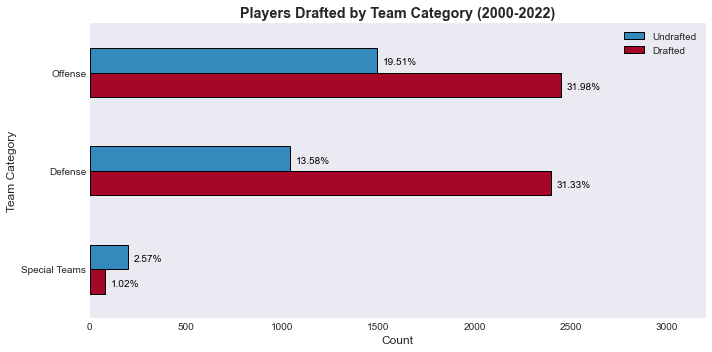

In [806]:
# plot visual breakdown of drafted by team category 
position_category = ['Offense', 'Defense', 'Special Teams']

data = {'Drafted': [total_offense_drafted, total_defense_drafted, total_st_drafted],
        'Undrafted': [total_offense_undrafted, total_defense_undrafted, total_st_undrafted]
       }

# create dataframe of positions & number of drafted
drafted = pd.DataFrame(data,
                       columns=['Undrafted', 'Drafted'], 
                       index = position_category)

plt.style.use('seaborn-dark')

fig, ax = plt.subplots(figsize=(10, 5))

drafted.plot(kind = 'barh',
             edgecolor = "black",
             linewidth = 1,
             ax = ax, stacked = False,
             xlim = (0, 3200))

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()+ 30, i.get_y() + 0.17, \
            str(round((i.get_width()/total)*100, 2))+'%', fontsize=10,
color='black')

# invert for largest on top 
ax.invert_yaxis()

plt.title('Players Drafted by Team Category (2000-2022)', weight = "bold")
plt.ylabel('Team Category')
plt.xlabel('Count')

plt.tight_layout()
plt.show()

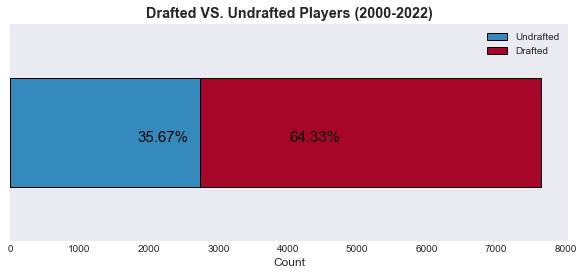

In [807]:
# create dict of drafted/undrafted with sums of each category
total = ['']

data = {'Undrafted': [drafted['Undrafted'].sum()],
        'Drafted': [drafted['Drafted'].sum()]
        }

# new drafted_total df
drafted_total = pd.DataFrame(data,
                       columns=['Undrafted', 'Drafted'],
                       index = total)

plt.style.use('seaborn-dark')

fig, ax = plt.subplots(figsize=(10, 4))

drafted_total.plot(kind = 'barh',
             edgecolor = "black",
             linewidth = 1,
             ax = ax, stacked = True)

# create a list to collect the plt.patches data
totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_width())

# set individual bar lables using above list
total = sum(totals)

# set individual bar lables using above list
for i in ax.patches:
    # get_width pulls left or right; get_y pushes up or down
    ax.text(i.get_width()-900, i.get_y()+.21, \
            str(round((i.get_width()/total)*100, 2))+'%', 
            fontsize=15,
            color='black')

ax.set_xlabel('Count')

ax.set(ylabel=None)
ax.set_title('Drafted VS. Undrafted Players (2000-2022)', weight = "bold")
ax.legend()

plt.show()

In [808]:
# get a sense of average metrics of drafted vs undrafted players
aggs = df.groupby('Drafted').agg(['mean', 'std'])
aggs

Wt                 40yd             Vertical            \
               mean        std      mean       std       mean       std   
Drafted                                                                   
0        238.130451  44.166829  4.827518  0.304425  32.126826  4.183633   
1        245.289313  45.624052  4.748869  0.301366  33.299948  4.178520   

             Bench            Broad Jump               3Cone            \
              mean       std        mean       std      mean       std   
Drafted                                                                  
0        19.449483  6.088900  113.015686  9.188386  7.338688  0.437711   
1        21.419760  6.421818  115.434121  9.330657  7.256132  0.403689   

          Shuttle              Height            
             mean       std      mean       std  
Drafted                                          
0        4.438029  0.274793  6.126918  0.222148  
1        4.379040  0.260637  6.161254  0.218508

## Below is just a check to see clustering of predictors

In [809]:
# a prelim check to see classification of drafted vs undrafted for each predictor
# sns.pairplot(hue = 'Drafted', data = df, height = 1.75)


## Train-Test Split

Based on the early exploratory data analysis on the drafted vs. undrafted players, this dataset is relatively imbalanced at a 2:1 ratio. Below we will perform a Train-Test Split and specify a `stratify=y` to ensure an even balance of drafted and undrafted player in the split. 

In [810]:
# feature selection, target variable = 'Drafted'
X = df.drop(['Drafted'], axis = 1)
y = df['Drafted']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state= 42)

In [811]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5738, 10)
(1913, 10)
(5738,)
(1913,)


In [812]:
# check that percent in y_train and y_test for drafted is balanced
print("Train percent Drafted:", y_train.value_counts(normalize=True)[1])
print("Test percent Drafted: ", y_test.value_counts(normalize=True)[1])

Train percent Drafted: 0.6432554897176717
Test percent Drafted:  0.643491897543126


### Handling Missing Values

In [813]:
X_train.isna().sum()

Pos              0
School           0
Wt               0
40yd           344
Vertical      1330
Bench         1943
Broad Jump    1378
3Cone         2173
Shuttle       2097
Height           0
dtype: int64

In [814]:
f = (X_train['40yd'].isna().sum()/X_train.shape[0]).round(2) * 100
v = (X_train['Vertical'].isna().sum()/X_train.shape[0]).round(2) * 100
b = (X_train['Bench'].isna().sum()/X_train.shape[0]).round(2) * 100
bj = (X_train['Broad Jump'].isna().sum()/X_train.shape[0]).round(2) * 100
c = (X_train['3Cone'].isna().sum()/X_train.shape[0]).round(2) * 100
s = (X_train['Shuttle'].isna().sum()/X_train.shape[0]).round(2) * 100

print(f'{f}% of 40yd is missing.')
print(f'{v}% of Vertical is missing.')
print(f'{b}% of Bench is missing.')
print(f'{bj}% of Broad Jump is missing.')
print(f'{c}% of 3Cone is missing.')
print(f'{s}% of Shuttle is missing.')

6.0% of 40yd is missing.
23.0% of Vertical is missing.
34.0% of Bench is missing.
24.0% of Broad Jump is missing.
38.0% of 3Cone is missing.
37.0% of Shuttle is missing.


A large majority of values are missing in this data set as evidenced from the above. I can fill in the NaNs with the average (mean) grouped by position. It would make sense to group by position since some players may be faster than others simply by the nature of their position and their overall build. 

In [815]:
X_train.head()

,Pos,School,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Height
6651,S,Kentucky,208.0,4.39,33.5,19.0,113.0,NaN,NaN,5.92
6261,DT,Fort Hays State,315.0,5.09,31.0,NaN,112.0,7.5,4.53,6.42
6174,QB,Nebraska,218.0,4.98,32.0,NaN,115.0,7.0,4.41,6.33
7742,EDGE,Cincinnati,228.0,4.67,33.0,NaN,120.0,NaN,4.37,6.42
7016,DL,Ohio State,264.0,NaN,NaN,NaN,NaN,NaN,NaN,6.42


In [816]:
# for each missing value in the columns, replace with the mean of that position 
X_train['40yd'] = X_train['40yd'].fillna(df.groupby('Pos')['40yd'].transform('mean'))
X_train['Vertical'] = X_train['Vertical'].fillna(df.groupby('Pos')['Vertical'].transform('mean'))
X_train['Bench'] = X_train['Bench'].fillna(df.groupby('Pos')['Bench'].transform('mean'))
X_train['Broad Jump'] = X_train['Broad Jump'].fillna(df.groupby('Pos')['Broad Jump'].transform('mean'))
X_train['3Cone'] = X_train['3Cone'].fillna(df.groupby('Pos')['3Cone'].transform('mean'))
X_train['Shuttle'] = X_train['Shuttle'].fillna(df.groupby('Pos')['Shuttle'].transform('mean'))

In [817]:
# create a helper function for the above for future use
def fill_missing(df):
    """ 
    Helper function that takes in columns from a dataframe and fills in the NaNs 
    with the means grouped by Position. Can be used for the training and test sets. 
    """
    missing_cols = ['40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle']
    
    for col in missing_cols:
        df[col] = df[col].fillna(df.groupby('Pos')[col].transform('mean'))
    
    return df
    

In [818]:
fill_missing(X_train)

,Pos,School,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Height
6651,S,Kentucky,208.0,4.390000,33.500000,19.000000,113.000000,7.002910,4.204769,5.92
6261,DT,Fort Hays State,315.0,5.090000,31.000000,27.552561,112.000000,7.500000,4.530000,6.42
6174,QB,Nebraska,218.0,4.980000,32.000000,19.300000,115.000000,7.000000,4.410000,6.33
7742,EDGE,Cincinnati,228.0,4.670000,33.000000,22.902439,120.000000,7.146000,4.370000,6.42
7016,DL,Ohio State,264.0,4.975784,30.680645,25.903226,111.595506,7.576301,4.614865,6.42
...,...,...,...,...,...,...,...,...,...,...
1599,RB,Northern Illinois,237.0,4.490000,31.000000,22.000000,114.000000,7.500000,4.150000,5.83
3257,DE,Wisconsin,266.0,4.860000,30.500000,24.000000,112.000000,7.680000,4.880000,6.42
4638,WR,Baylor,208.0,4.520000,32.500000,11.000000,119.000000,7.010000,4.320000,6.17
3229,TE,Fresno State,251.0,4.890000,26.500000,20.157576,107.000000,7.650000,4.550000,6.42


In [819]:
X_train.isna().sum()

Pos            0
School         0
Wt             0
40yd           0
Vertical       0
Bench          0
Broad Jump     0
3Cone         76
Shuttle       76
Height         0
dtype: int64

After filling in the missing values with the means, we still have missing values for 3Cone and Shuttle drills. 

Upon closer inspection, Kickers do not perform in the 3Cone and Shuttle drills. This makes sense because there really is no need for them to perform these drills for their particular skillsets. 

In [820]:
# confirm that kickers do not perform 3Cone and Shuttle Drills
# isolate for dataframe with just Kickers
kickers = X_train[X_train['Pos'] == 'K']
display(kickers.head())
print("3Cone Mean for Kickers:", kickers['3Cone'].mean(), ", Count of NaN:", kickers['3Cone'].isna().sum())
print("Shuttle Mean for Kickers:", kickers['Shuttle'].mean(), ", Count of NaN:", kickers['Shuttle'].isna().sum())

,Pos,School,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Height
3021,K,USC,227.0,4.570000,33.5,25.0,113.5,NaN,NaN,6.17
884,K,North Dakota,190.0,4.910984,33.5,15.2,113.5,NaN,NaN,6.25
7431,K,Stanford,204.0,4.910984,33.5,15.2,113.5,NaN,NaN,6.17
6639,K,LSU,184.0,4.910984,33.5,15.2,113.5,NaN,NaN,5.83
6605,K,Oklahoma,213.0,4.910984,33.5,15.2,113.5,NaN,NaN,5.75


3Cone Mean for Kickers: nan , Count of NaN: 76
Shuttle Mean for Kickers: nan , Count of NaN: 76


There are a few options here; do we fill in the NaNs with 0? This would have a minor impact on the averages for 3Cone and Shuttle, and pull the mean closer to 0. Likely filling these values with 0s will not impact the decision whether a team would draft a kicker since they did not participate in these drills. 

Another option is to drop kickers from the original `df` and just analyze all other positions. Using domain knowledge and a brief analysis on the percentage that kickers make up the dataset (as part of the Special Teams category), dropping these values will not likely impact whether a player is drafted or not. Generally speaking, very few kickers are ever drafted and are not a critical position of need in football. However, dropping kickers from the `X_train` will cause data leakage as rows will be removed from the X_train set. 

We can always reanalyze the kickers and special teams category/sub-group and drop 3Cone and Shuttle columns later. To avoid data leakage, we will fill NaNs with 0s. 

In [821]:
# fill NaNs with 0
X_train = X_train.fillna(0)

In [822]:
# check 
X_train.isna().sum()

Pos           0
School        0
Wt            0
40yd          0
Vertical      0
Bench         0
Broad Jump    0
3Cone         0
Shuttle       0
Height        0
dtype: int64

In [823]:
y_train.shape

(5738,)

In [824]:
X_train.shape

(5738, 10)

In [825]:
# final describe check
# show all rows
pd.set_option('display.max_rows', None)
# check breakdown of summary statistics by Pos
X_train.groupby('Pos').describe().T

Pos                        C          CB          DB          DE          DL  \
Wt         count  128.000000  574.000000   42.000000  384.000000   94.000000   
           mean   302.265625  192.721254  195.547619  268.828125  289.489362   
           std      8.578938    8.763262   11.555175   13.366950   23.394120   
           min    263.000000  169.000000  177.000000  234.000000  248.000000   
           25%    299.000000  187.000000  186.000000  260.000000  266.500000   
           50%    302.000000  192.000000  195.000000  268.000000  290.000000   
           75%    307.250000  198.000000  204.750000  277.000000  306.750000   
           max    327.000000  221.000000  226.000000  310.000000  342.000000   
40yd       count  128.000000  574.000000   42.000000  384.000000   94.000000   
           mean     5.224975    4.495323    4.521983    4.835234    4.986254   
           std      0.162620    0.093877    0.113708    0.143306    0.199650   
           min      4.830000    4.230000    4.310000    4.360000    4.520000   
           25%      5.130000    4.440000    4.442500    4.740000    4.872500   
           50%      5.232971    4.492830    4.510000    4.840000    4.975784   
           75%      5.330000    4.550000    4.597500    4.920000    5.127500   
           max      5.840000    4.940000    4.760000    5.240000    5.460000   
Vertical   count  128.000000  574.000000   42.000000  384.000000   94.000000   
           mean    28.128041   35.966604   36.464286   32.879161   30.497152   
           std      2.627250    2.417797    3.629810    2.889005    3.030152   
           min     21.000000   29.000000   29.000000   24.500000   23.500000   
           25%     26.875000   34.500000   34.125000   31.500000   29.000000   
           50%     28.117857   36.002504   35.750000   32.988861   30.680645   
           75%     29.000000   37.375000   39.500000   34.500000   32.000000   
           max     37.500000   45.000000   43.000000   42.000000   38.000000   
Bench      count  128.000000  574.000000   42.000000  384.000000   94.000000   
           mean    26.242504   14.465951   13.760037   23.754172   25.779341   
           std      4.288880    3.434335    3.849558    4.317937    4.621818   
           min     13.000000    2.000000    6.000000   13.000000   17.000000   
           25%     24.000000   13.000000   11.000000   21.750000   22.000000   
           50%     26.155405   14.496466   13.980392   23.778338   25.903226   
           75%     28.250000   16.000000   17.000000   25.000000   28.000000   
           max     41.000000   27.000000   20.000000   45.000000   40.000000   
Broad Jump count  128.000000  574.000000   42.000000  384.000000   94.000000   
           mean   101.835156  121.985494  124.761905  114.149779  111.362778   
           std      5.158348    4.735756    6.195236    5.247314    7.001099   
           min     89.000000  108.000000  110.000000  101.000000   96.000000   
           25%     99.000000  120.000000  120.500000  111.000000  107.250000   
           50%    101.850000  121.989950  125.000000  114.705000  111.595506   
           75%    104.000000  124.000000  128.000000  117.000000  115.000000   
           max    118.000000  137.000000  136.000000  134.000000  127.000000   
3Cone      count  128.000000  574.000000   42.000000  384.000000   94.000000   
           mean     7.705472    6.948244    7.030387    7.322945    7.581176   
           std      0.209514    0.162999    0.192933    0.215816    0.303491   
           min      7.220000    6.280000    6.630000    6.820000    6.870000   
           25%      7.577500    6.920000    6.900000    7.227500    7.450000   
           50%      7.719485    6.944462    7.020000    7.322321    7.576301   
           75%      7.810000    6.970000    7.137500    7.392500    7.700000   
           max      8.260000    7.550000    7.650000    8.590000    8.580000   
Shuttle    count  128.000000  574.000000   42.000000  384.000000   94.000000   


## Pipeline

In [826]:
from sklearn.pipeline import Pipeline

# this will allow us to visualize the pipeline (may not be available in learn-env)
from sklearn import set_config
set_config(display= 'diagram')

In [827]:
# reset display to normal
pd.set_option('display.max_rows', 500)
X_train

,Pos,School,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Height
6651,S,Kentucky,208.0,4.390000,33.500000,19.000000,113.000000,7.002910,4.204769,5.92
6261,DT,Fort Hays State,315.0,5.090000,31.000000,27.552561,112.000000,7.500000,4.530000,6.42
6174,QB,Nebraska,218.0,4.980000,32.000000,19.300000,115.000000,7.000000,4.410000,6.33
7742,EDGE,Cincinnati,228.0,4.670000,33.000000,22.902439,120.000000,7.146000,4.370000,6.42
7016,DL,Ohio State,264.0,4.975784,30.680645,25.903226,111.595506,7.576301,4.614865,6.42
...,...,...,...,...,...,...,...,...,...,...
1599,RB,Northern Illinois,237.0,4.490000,31.000000,22.000000,114.000000,7.500000,4.150000,5.83
3257,DE,Wisconsin,266.0,4.860000,30.500000,24.000000,112.000000,7.680000,4.880000,6.42
4638,WR,Baylor,208.0,4.520000,32.500000,11.000000,119.000000,7.010000,4.320000,6.17
3229,TE,Fresno State,251.0,4.890000,26.500000,20.157576,107.000000,7.650000,4.550000,6.42


In [828]:
# define numeric columns to be standard scaled
num_cols = X_train.select_dtypes(['int', 'float']).columns

In [904]:
# define categorical columns to be OHE
cat_cols = X_train.select_dtypes(['object']).columns

## Define the seperate pipelines

#### Numeric & Nominal Pipelines

In [909]:
# define numeric transformation pipeline
numeric_pipeline = Pipeline([('numnorm', StandardScaler())]) # apply a standard scaler

# define a nominal transformation pipeline
nominal_pipeline = Pipeline([
    ('onehotenc', OneHotEncoder(categories = 'auto',
                                sparse = False, 
                                drop = 'first')), # ohe the cat variables
    ('onehotnorm', MaxAbsScaler())]) # apply a MaxAbsScaler


Unite the numeric and nominal pipelines into the ColumnTransformer.

In [911]:
# transform the selected columns with nominal, and numeric pipelines
ct = ColumnTransformer(transformers = 
    [("nominalpipe", nominal_pipeline, cat_cols), # ohe and MaxAbsScale the Pos and School variables
     ("numpipe", numeric_pipeline, num_cols)])

# Create a pipeline containing the single column transformer
ct_pipe = Pipeline(steps=[
    ("col_transformer", ct)
])

# Use the pipeline to fit and transform the data
transformed_data = ct_pipe.fit_transform(X_train)
transformed_data


array([[ 0.        ,  0.        ,  0.        , ..., -0.18274522,
        -0.22716004, -1.03878718],
       [ 0.        ,  0.        ,  0.        , ...,  0.36202586,
         0.3568671 ,  1.23351275],
       [ 0.        ,  0.        ,  0.        , ..., -0.18593459,
         0.14137932,  0.82449877],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.17497538,
        -0.02023652,  0.09736279],
       [ 0.        ,  0.        ,  0.        , ...,  0.52641399,
         0.39278173,  1.23351275],
       [ 1.        ,  0.        ,  0.        , ..., -0.24679997,
        -0.30185407, -1.81136916]])

In [912]:
X_train

,Pos,School,Wt,40yd,Vertical,Bench,Broad Jump,3Cone,Shuttle,Height
6651,S,Kentucky,208.0,4.390000,33.500000,19.000000,113.000000,7.002910,4.204769,5.92
6261,DT,Fort Hays State,315.0,5.090000,31.000000,27.552561,112.000000,7.500000,4.530000,6.42
6174,QB,Nebraska,218.0,4.980000,32.000000,19.300000,115.000000,7.000000,4.410000,6.33
7742,EDGE,Cincinnati,228.0,4.670000,33.000000,22.902439,120.000000,7.146000,4.370000,6.42
7016,DL,Ohio State,264.0,4.975784,30.680645,25.903226,111.595506,7.576301,4.614865,6.42
...,...,...,...,...,...,...,...,...,...,...
1599,RB,Northern Illinois,237.0,4.490000,31.000000,22.000000,114.000000,7.500000,4.150000,5.83
3257,DE,Wisconsin,266.0,4.860000,30.500000,24.000000,112.000000,7.680000,4.880000,6.42
4638,WR,Baylor,208.0,4.520000,32.500000,11.000000,119.000000,7.010000,4.320000,6.17
3229,TE,Fresno State,251.0,4.890000,26.500000,20.157576,107.000000,7.650000,4.550000,6.42


In [913]:
# Extract the category labels from the OHE within the pipeline
encoder = ct.named_transformers_["nominalpipe"]
category_labels = encoder.categories_[0]

# Make a dataframe with the relevant columns
pd.DataFrame(transformed_data, columns=np.append(category_labels, "num_cols"))

AttributeError: 'Pipeline' object has no attribute 'categories_'

In [914]:
# Extract the category labels from the OHE within the pipeline
encoder = ColumnTransformer.named_transformers_["nominalpipe"]
category_labels = encoder.categories_[0]

TypeError: 'property' object is not subscriptable

In [915]:
# inspect the transformed X_Train
pd.DataFrame(ct.fit_transform(X_train))

,0,1,2,3,4,5,6,7,8,9,...,338,339,340,341,342,343,344,345,346,347
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.768205,-1.292828,0.167087,-0.201004,-0.164736,-0.182745,-0.227160,-1.038787
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.587333,1.031585,-0.473770,1.282397,-0.279103,0.362026,0.356867,1.233513
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.548061,0.666320,-0.217427,-0.148970,0.063996,-0.185935,0.141379,0.824499
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.327917,-0.363063,0.038916,0.475856,0.635828,-0.025930,0.069550,1.233513
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.464600,0.652322,-0.555634,0.996328,-0.325363,0.445646,0.509262,1.233513
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5733,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.129788,-0.960769,-0.473770,0.319332,-0.050370,0.362026,-0.325511,-1.447801
5734,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.508629,0.267849,-0.601942,0.666222,-0.279103,0.559292,0.985373,1.233513
5735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.768205,-0.861151,-0.089256,-1.588566,0.521462,-0.174975,-0.020237,0.097363
5736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.178413,0.367467,-1.627313,-0.000228,-0.850934,0.526414,0.392782,1.233513


In [916]:
# check columntransformer
ct

ColumnTransformer(transformers=[('nominalpipe',
                                 Pipeline(steps=[('onehotenc',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False)),
                                                 ('onehotnorm',
                                                  MaxAbsScaler())]),
                                 Index(['Pos', 'School'], dtype='object')),
                                ('numpipe',
                                 Pipeline(steps=[('numnorm',
                                                  StandardScaler())]),
                                 Index(['Wt', '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle',
       'Height'],
      dtype='object'))])

## 1st Model - Baseline

In [917]:
# build baseline log reg pipepline 
steps = [('preprocess', ct), 
         ('model', LogisticRegression(random_state = 42))]

base_log_reg_pipeline = Pipeline(steps)

base_log_reg_pipeline

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False)),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  Index(['Pos', 'School'], dtype='object')),
                                                 ('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['Wt', '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle',
       'Height'],
      dtype='object'))])),
                ('model', LogisticRegression(random_state=42))])

In [918]:
base_log_reg_pipeline.fit(X_train, y_train)

/Users/eric/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False)),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  Index(['Pos', 'School'], dtype='object')),
                                                 ('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['Wt', '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle',
       'Height'],
      dtype='object'))])),
                ('model', LogisticRegression(random_state=42))])

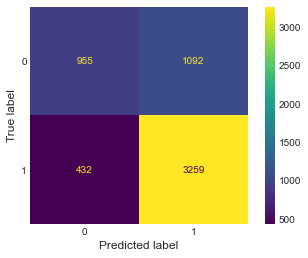

In [919]:
plot_confusion_matrix(base_log_reg_pipeline, X_train, y_train)

## Cross Validation Pipeline
### Using `StratifiedKFold`

In [920]:
def cross_validation_pipe(X_train, y_train, estimator, num_split = 10):
    
    score_train_list = []
    score_val_list = []

    # Instantiate a splitter object and loop over its result
    kfold = StratifiedKFold()
    for fold, (train_index, val_index) in enumerate(kfold.split(X_train, y_train)):
        # Extract train and validation subsets using the provided indices
        X_t, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_t, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

        # Clone the provided model and fit it on the train subset
        temp_model = clone(estimator)
        temp_model.fit(X_t, y_t)
        
        # now how did we do?
        accuracy_train = estimator.score(X_t, y_t) # X_train and y_train folds
        accuracy_val = estimator.score(X_val, y_val) # X_train and y_train validation folds
        score_val_list.append(accuracy_val)
        score_train_list.append(accuracy_train)
    
    return {'train': np.mean(score_train_list), 'validation': np.mean(score_val_list)}

In [921]:
cross_validation_pipe(X_train, y_train, base_log_reg_pipeline)

/Users/eric/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/eric/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

{'train': 0.7344022334120608, 'validation': 0.7344022734660027}

/Users/eric/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


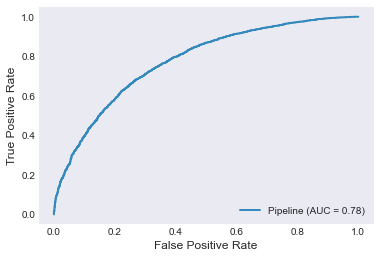

In [922]:
# fit and plot roc curve
base_log_reg_pipeline.fit(X_train, y_train)
plot_roc_curve(base_log_reg_pipeline, X_train, y_train)
plt.show()

## 2nd Model - Tuned Logistic Regression
Lets define a new model and try to improve on the baseline logistic regression model. 


In [865]:
# build new log reg pipepline 
steps = [('preprocess', ct), 
         ('logreg', LogisticRegression(random_state = 42))]

log_reg_pipe2 = Pipeline(steps)

log_reg_pipe2

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('onehotenc',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse=False)),
                                                                  ('onehotnorm',
                                                                   MaxAbsScaler())]),
                                                  ['Pos', 'School']),
                                                 ('numpipe',
                                                  Pipeline(steps=[('numnorm',
                                                                   StandardScaler())]),
                                                  Index(['Wt', '40yd', 'Vertical', 'Bench', 'Broad Jump', '3Cone', 'Shuttle',
       'Height'],
      dtype='object'))])),
                ('logreg', LogisticRegression(random_state=42))])

In [866]:
# define new parameters in the grid
pipe_grid = {'logreg__penalty': ['l2', 'l1', 'elasticnet'],
             'logreg__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             'logreg__C': [0.0001, 0.001, 0.01, 0.1, 1],  
             'logreg__max_iter': [1e2, 1e3, 1e4, 1e5]}  

# note: default scoring is aaccuracy
gs_pipe2 = GridSearchCV(estimator = log_reg_pipe2, # runs through the original pipeline
                       param_grid = pipe_grid)  # goes through all parameters in the defined grid


In [867]:
gs_pipe2.fit(X_train, y_train)

ValueError: Found unknown categories ['Hobart & William Smith', 'Texas College', 'Delaware State', 'Kent St.', 'Drake', 'Texas A&M-Kingsville', 'Pittsburg State', 'Charleston', 'Western Illinois', 'Gustavus Adolphus', 'Central Missouri State', 'Hofstra', 'San Diego', 'Lane (TN)', 'West Georgia'] in column 1 during transform

## 3rd Model - Reducing Regularization

In [62]:
model_less_regularization = LogisticRegression(random_state = 42,
                                               C = 0.01) # optimum C, increasing C is worse logloss

In [63]:
less_regularization_train_scores, less_regularization_val_scores = custom_cross_val_score(model_less_regularization, X_train, y_train)

print("Previous Model (Standard Scaler)")
print("Train average:     ", -preprocessed_train_scores.mean())
print("Validation average:", -preprocessed_neg_log_loss_cv.mean())
print()
print("Current Model (Reduced Regularization)")
print("Train average:     ", -less_regularization_train_scores.mean())
print("Validation average:", -less_regularization_val_scores.mean())

Previous Model (Standard Scaler)
Train average:      0.517329145866608
Validation average: 0.6388027153309962

Current Model (Reduced Regularization)
Train average:      0.532299282932194
Validation average: 0.5981987767311354


/Users/eric/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


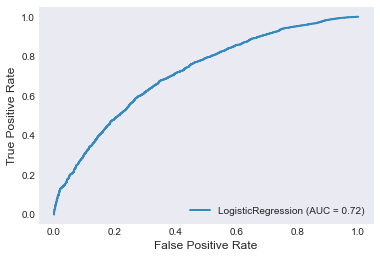

In [64]:
# fit and plot roc curve
model_less_regularization.fit(X_train, y_train)
plot_roc_curve(model_less_regularization, X_train, y_train)
plt.show()

**Conclusion**: 
- Less regularization (ie. higher C value) creates a worse model as the Validation Average increases as C increases. The optimum C value is 0.01 after several iterations. 

## 4th Model - Increase Max Iterations

In [65]:
model_more_iterations = LogisticRegression(random_state = 42,
                                           penalty='none', 
                                           max_iter=1e10) # adjust 

In [66]:
model_more_iterations_train_scores, model_more_iterations_val_scores = custom_cross_val_score(model_more_iterations, X_train, y_train)

print("Previous Model (Reduced Regularization)")
print("Train average:     ", -less_regularization_train_scores.mean())
print("Validation average:", -less_regularization_val_scores.mean())
print()
print("Current Model (More Iterations)")
print("Train average:     ", -model_more_iterations_train_scores.mean())
print("Validation average:", -model_more_iterations_val_scores.mean())

Previous Model (Reduced Regularization)
Train average:      0.532299282932194
Validation average: 0.5981987767311354

Current Model (More Iterations)
Train average:      0.5172697886653066
Validation average: 0.7829644752028485


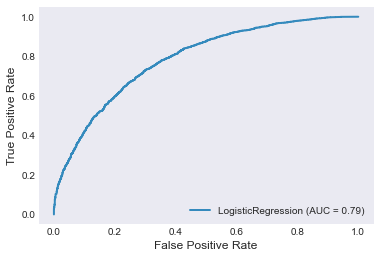

In [67]:
# fit and plot roc curve
model_more_iterations.fit(X_train, y_train)
plot_roc_curve(model_more_iterations, X_train, y_train)
plt.show()

**Conclusion**: 
- Increasing the max iterations solves the Convergence Problem and slightly increases the AUC, however, the validation log loss average goes up which isn't good. Lets try different solvers and see how this fares. 

# Try Different Solvers
## 5th Model - lbfgs (default), penalty "l2"

In [68]:
# current default hyperparameters
print("solver:", model_more_iterations.get_params()["solver"])
print("penalty:", model_more_iterations.get_params()["penalty"])

solver: lbfgs
penalty: none


In [85]:
# try lbfgs as solver
model_lbfgs_l2_solver = LogisticRegression(
                            random_state = 42,
                            C = 0.01,
                            solver = "lbfgs",
                            penalty = "l2",
                            max_iter = 1e10, # fixes ConvergenceWarning
                            tol=1) # best scores is when tol = 1

alternative_solver_train_scores, alternative_solver_val_scores = custom_cross_val_score(
    model_lbfgs_l2_solver,
    X_train,
    y_train
)

print("Previous Model (Less Regularization)")
print("Train average:     ", -less_regularization_train_scores.mean())
print("Validation average:", -less_regularization_val_scores.mean())
print()
print("Current Model (lbgfs - l2 Solver)")
print("Train average:     ", -alternative_solver_train_scores.mean())
print("Validation average:", -alternative_solver_val_scores.mean())

Previous Model (Less Regularization)
Train average:      0.532299282932194
Validation average: 0.5981987767311354

Current Model (lbgfs - l2 Solver)
Train average:      0.5323056096806968
Validation average: 0.5981391702365106


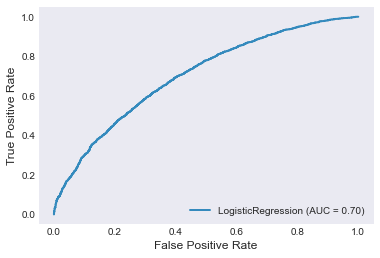

In [86]:
model_lbfgs_l2_solver.fit(X_train, y_train)
plot_roc_curve(model_lbfgs_l2_solver, X_train, y_train)

**Conclusion**: 
- The model performs the best so far with but with a worse ROC curve with a `lbfgs` solver.

## 6th Model - Sag

In [94]:
# try saga as solver
model_sag_solver = LogisticRegression(
                            random_state = 42,
                            C = 0.01,
                            solver = "sag",
                            penalty = "l2",
                            max_iter = 1e5, # fixes ConvergenceWarning
                            tol=1) # best scores is when tol = 1

alternative_solver_train_scores, alternative_solver_val_scores = custom_cross_val_score(
    model_sag_solver, # change as needed
    X_train,
    y_train
)

print("Current Model (Sag Solver)")
print("Train average:     ", -alternative_solver_train_scores.mean())
print("Validation average:", -alternative_solver_val_scores.mean())

Current Model (Sag Solver)
Train average:      0.5890455299809834
Validation average: 0.629125856178721


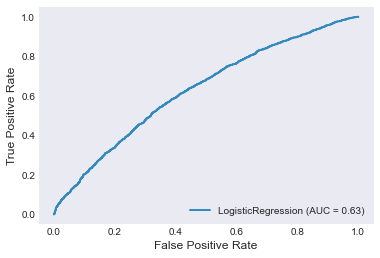

In [95]:
model_sag_solver.fit(X_train, y_train)
plot_roc_curve(model_sag_solver, X_train, y_train)

**Conclusion**: 
- The model performs worse with a 0.629 log loss and the ROC curve suffers with a `sag` solver.

## 7th Model - newton-cg

In [96]:
# try newton as solver
model_newton_solver = LogisticRegression(
                            random_state = 42,
                            C = 0.01,
                            solver = "newton-cg",
                            penalty = "l2",
                            max_iter = 1e10, # fixes ConvergenceWarning
                            tol=1) # best scores is when tol = 1

alternative_solver_train_scores, alternative_solver_val_scores = custom_cross_val_score(
    model_newton_solver, # change as needed
    X_train,
    y_train
)

print("Current Model (Newton Solver)")
print("Train average:     ", -alternative_solver_train_scores.mean())
print("Validation average:", -alternative_solver_val_scores.mean())

Current Model (Newton Solver)
Train average:      0.5323186507253969
Validation average: 0.5982166252201812


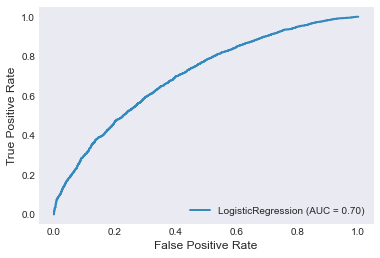

In [97]:
model_newton_solver.fit(X_train, y_train)
plot_roc_curve(model_newton_solver, X_train, y_train)

**Conclusion**: 
- Newton Solver is looking more promising based on the ROC curve, but log loss is still not as good as the baseline. 

## Use `SelectFromModel`

In [99]:
selector = SelectFromModel(baseline_model)

selector.fit(X_train, y_train)

/Users/eric/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SelectFromModel(estimator=LogisticRegression(random_state=42))

In [100]:
thresh = selector.threshold_
thresh

0.08154845337145639

In [101]:
# counts of true and false
sup = selector.get_support()
unique, counts = np.unique(sup, return_counts=True)
print(np.asarray((unique, counts)).T)

[[  0 272]
 [  1  78]]


In [102]:
def select_important_features(X, selector):
    """
    Given a DataFrame and a selector, use the selector to choose
    the most important columns
    """
    imps = dict(zip(X.columns, selector.get_support()))
    selected_array = selector.transform(X)
    selected_df = pd.DataFrame(selected_array,
                               columns=[col for col in X.columns if imps[col]],
                               index=X.index)
    return selected_df

In [103]:
X_train_selected = select_important_features(X=X_train, selector=selector)

In [104]:
logreg_sel = LogisticRegression(random_state=2022,C = 0.01)

logreg_sel.fit(X_train_selected, y_train)

LogisticRegression(C=0.01, random_state=2022)

In [105]:
alternative_solver_train_scores, alternative_solver_val_scores = custom_cross_val_score(
    logreg_sel, 
    X_train_selected,
    y_train
)

print("Current Model (Select From Model)")
print("Train average:     ", -alternative_solver_train_scores.mean())
print("Validation average:", -alternative_solver_val_scores.mean())

Current Model (Select From Model)
Train average:      0.5863127910929771
Validation average: 0.5998632646071822


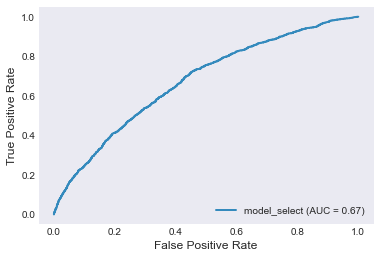

In [106]:
fig, ax = plt.subplots()

plot_roc_curve(logreg_sel, X_train_selected, y_train, 
               name='model_select', ax=ax)

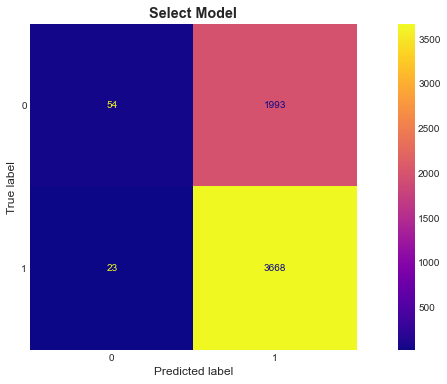

In [108]:
# plot baseline model confusion matrix
fix, axes = plt.subplots(figsize=(15, 6))

axes.set_title("Select Model", weight = 'bold')

plot_confusion_matrix(logreg_sel, X_train_selected, y_train,
                      ax=axes, cmap="plasma")

# KNN Test Run

In [157]:
# Relevant imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Creating the model
knn_baseline_model = KNeighborsClassifier()

# Perform cross-validation
knn_baseline_log_loss = -cross_val_score(knn_baseline_model, X_train_selected, y_train, scoring="neg_log_loss").mean()

knn_baseline_log_loss

2.3300370106285113

Much lower log loss than the baseline lin reg

In [158]:
knn_second_model = KNeighborsClassifier(n_neighbors=41)

knn_second_log_loss = -cross_val_score(knn_second_model, X_train_selected, y_train, scoring="neg_log_loss").mean()
knn_second_log_loss

0.6018917697370897

In [159]:
knn_third_model = KNeighborsClassifier(n_neighbors=31, metric = 'manhattan')

knn_third_log_loss = -cross_val_score(knn_third_model, X_train_selected, y_train, scoring="neg_log_loss").mean()
knn_third_log_loss

0.6021903864970074

In [160]:
knn_fourth_model = KNeighborsClassifier(n_neighbors=31, metric = 'euclidean')

knn_fourth_log_loss = -cross_val_score(knn_fourth_model, X_train_selected, y_train, scoring="neg_log_loss").mean()
knn_fourth_log_loss

0.6031698103066763

# Decision Tree Test

In [163]:
from sklearn.tree import DecisionTreeClassifier

dtree_baseline_model = DecisionTreeClassifier(random_state=42)

dtree_baseline_log_loss = -cross_val_score(dtree_baseline_model, X_train_selected, y_train, scoring="neg_log_loss").mean()
dtree_baseline_log_loss

12.127515539753276

In [164]:
dtree_second_model = DecisionTreeClassifier(random_state=42, min_samples_leaf=160)

dtree_second_log_loss = -cross_val_score(dtree_second_model, X_train_selected, y_train, scoring="neg_log_loss").mean()
dtree_second_log_loss

0.6142103198938127

In [165]:
dtree_third_model = DecisionTreeClassifier(random_state=42,
                                           min_samples_leaf=160,
                                           min_samples_split =80,
                                           max_depth = 100)

dtree_third_log_loss = -cross_val_score(dtree_third_model, X_train_selected, y_train, scoring="neg_log_loss").mean()
dtree_third_log_loss

0.6142103198938127

In [166]:
dtree_third_model.fit(X_train_selected, y_train)

DecisionTreeClassifier(max_depth=100, min_samples_leaf=160,
                       min_samples_split=80, random_state=42)

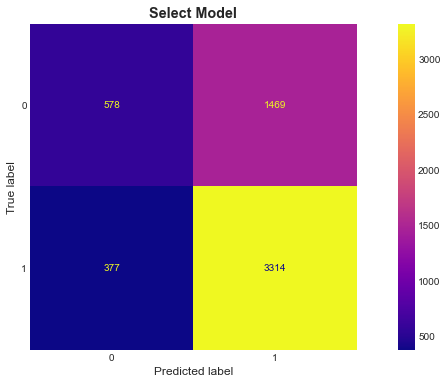

In [168]:
fix, axes = plt.subplots(figsize=(15, 6))

axes.set_title("Select Model", weight = 'bold')

plot_confusion_matrix(dtree_third_model, X_train_selected, y_train,
                      ax=axes, cmap="plasma")

In [ ]:
plot_roc_curve(logreg_model, X_train_scaled, y_train)